In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

First, we will load the data sets and merge them into a single dataframe. We will join them on customer ID

In [ ]:

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')


In [ ]:
merged_data = pd.merge(transactions, customers, on='CustomerID')


In [ ]:
merged_data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


Now, we will perform feature engineering by aggregating transactional and profile data. For clustering we will consider the following:
- The total amount a customer spends
- The quantity a customer purchases
- The number of transactions (helps determine if the customer is a frequent customer)
- The average cost price of the items the customer buys
- The number of days since the customer signed up
- The region of the customer

In [ ]:
# Step 1: Feature Engineering
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
merged_data['SignupDate'] = pd.to_datetime(merged_data['SignupDate'])

# Aggregate metrics per customer
customer_metrics = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',   # Total value spent
    'Quantity': 'sum',     # Total quantity purchased
    'TransactionID': 'count',  # Number of transactions
    'Price': 'mean',       # Average price of product
    'SignupDate': lambda x: (pd.Timestamp.now() - x.min()).days,  # Time since signup
    'Region': 'first'      # Take the region for the customer
}).reset_index()

customer_metrics.columns = [
    'CustomerID', 'TotalValueSpent', 'TotalQuantityPurchased', 'NumTransactions',
    'AveragePrice',  'TimeSinceSignup', 'Region'
]

One-hot encode Region


In [ ]:
encoder = OneHotEncoder()
region_encoded = encoder.fit_transform(customer_metrics[['Region']]).toarray()
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))

customer_data = pd.concat([customer_metrics.drop('Region', axis=1), region_encoded_df], axis=1)

Normalize numerical data using Standard Scaler


In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop('CustomerID', axis=1))

# Clustering using K Means

First we will decide the optimal k value by comparing all the DB scores for k values from 2 to 10

In [ ]:

k_range = range(2, 11)

db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    db_score = davies_bouldin_score(scaled_data, labels)
    db_scores.append(db_score)
    print(f"DB Score for k={k}: {db_score:.4f}")

DB Score for k=2: 1.9436
DB Score for k=3: 1.7691
DB Score for k=4: 1.6118
DB Score for k=5: 1.2417
DB Score for k=6: 1.3981
DB Score for k=7: 1.2427
DB Score for k=8: 1.2529
DB Score for k=9: 1.3332
DB Score for k=10: 1.3244


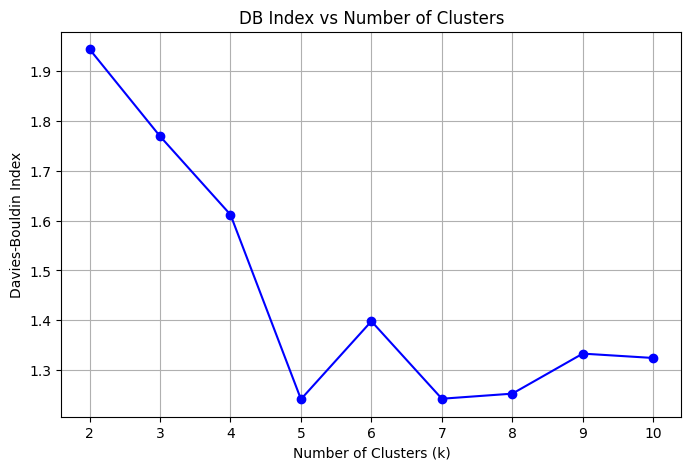

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(k_range, db_scores, marker='o', linestyle='-', color='b')
plt.xticks(k_range)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("DB Index vs Number of Clusters")
plt.grid()
plt.show()

In [ ]:
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")


Optimal number of clusters: 5


When comparing DB Scores, we got optimal k as 5. We will use elbow method to verify if this k is optimal. We will plot a graph between Within-Cluster Sum of Squares vs k.
As seen in the graph, there is an inflection point at k = 5. Hence, k = 5 is an optimal choice

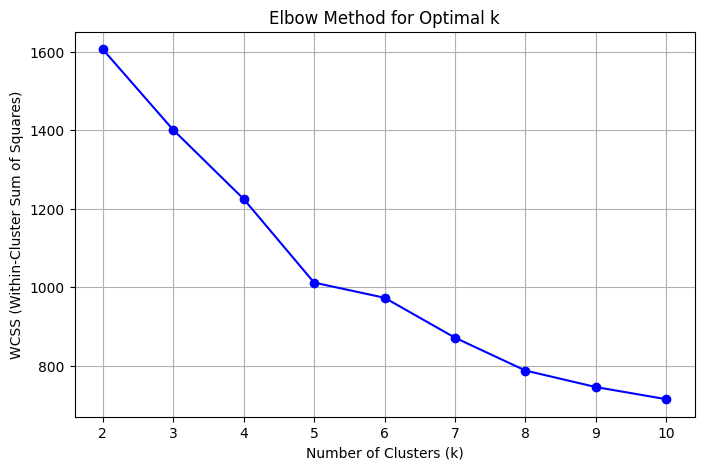

In [ ]:
# List to store WCSS (Within-Cluster Sum of Squares)
wcss = []

# Range of k values to evaluate
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.xticks(k_range)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.show()


In [ ]:

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)



Visualization of Clusters using t-SNE

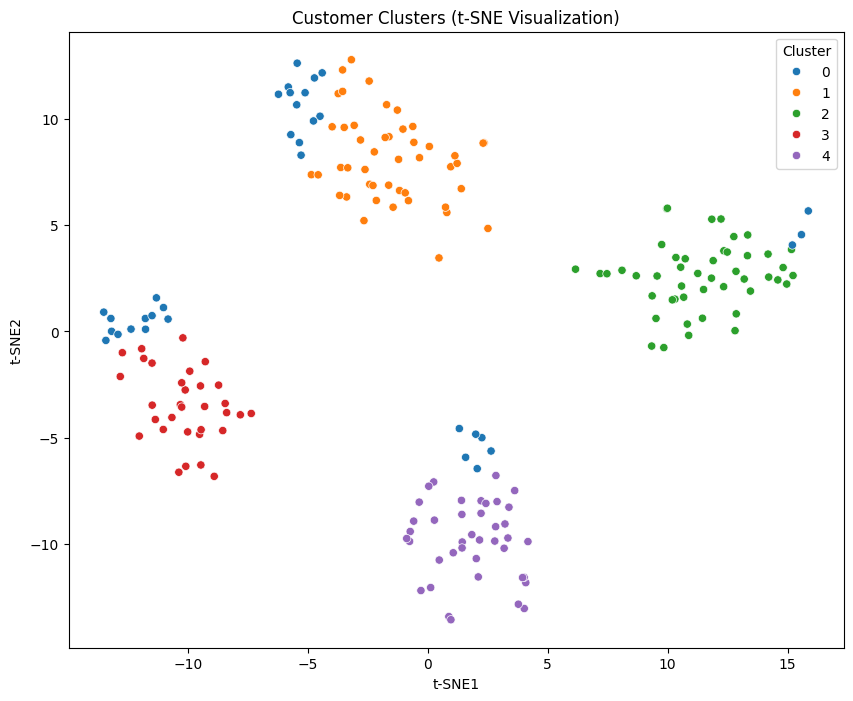

In [ ]:

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)

customer_data['t-SNE1'] = tsne_results[:, 0]
customer_data['t-SNE2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2', hue='Cluster', data=customer_data,
    palette='tab10', legend='full'
)
plt.title("Customer Clusters (t-SNE Visualization)")
plt.show()


Optimal DB Index value for KNN

In [ ]:

final_db_index = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f"Davies-Bouldin Index for Optimal Clustering (KNN with k = 5): {final_db_index}")

Davies-Bouldin Index for Optimal Clustering (KNN with k = 5): 1.2417022871412584


Printing Cluster information

In [ ]:
cluster_groups = customer_data.groupby('Cluster')['CustomerID'].apply(list)

for cluster_id, customers in cluster_groups.items():
    print(f"Cluster {cluster_id}:")
    print(customers)
    print(f"{len(customers)} customers")
    print("-" * 50)


Cluster 0:
['C0004', 'C0008', 'C0012', 'C0013', 'C0021', 'C0028', 'C0041', 'C0045', 'C0054', 'C0059', 'C0065', 'C0068', 'C0075', 'C0082', 'C0084', 'C0087', 'C0093', 'C0099', 'C0101', 'C0102', 'C0104', 'C0109', 'C0113', 'C0141', 'C0143', 'C0145', 'C0155', 'C0156', 'C0162', 'C0163', 'C0165', 'C0173', 'C0175', 'C0188']
34 customers
--------------------------------------------------
Cluster 1:
['C0001', 'C0003', 'C0006', 'C0011', 'C0025', 'C0031', 'C0032', 'C0039', 'C0048', 'C0052', 'C0071', 'C0076', 'C0077', 'C0083', 'C0085', 'C0091', 'C0095', 'C0096', 'C0107', 'C0108', 'C0112', 'C0118', 'C0120', 'C0126', 'C0129', 'C0130', 'C0133', 'C0137', 'C0147', 'C0148', 'C0150', 'C0151', 'C0152', 'C0153', 'C0158', 'C0168', 'C0169', 'C0171', 'C0174', 'C0181', 'C0184', 'C0187', 'C0190', 'C0191', 'C0192', 'C0195']
46 customers
--------------------------------------------------
Cluster 2:
['C0009', 'C0010', 'C0014', 'C0017', 'C0019', 'C0023', 'C0037', 'C0044', 'C0051', 'C0053', 'C0057', 'C0060', 'C0061',

# Clustering using DBScan

We will first determine eps using NearestNeighbors and plot the elbow graph


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

Sorted distances of 4th nearest neighbour to find the elbow
As seen in the graph, there is an inflection between 2 to 3. Hence, we will take eps as 3 for best results.

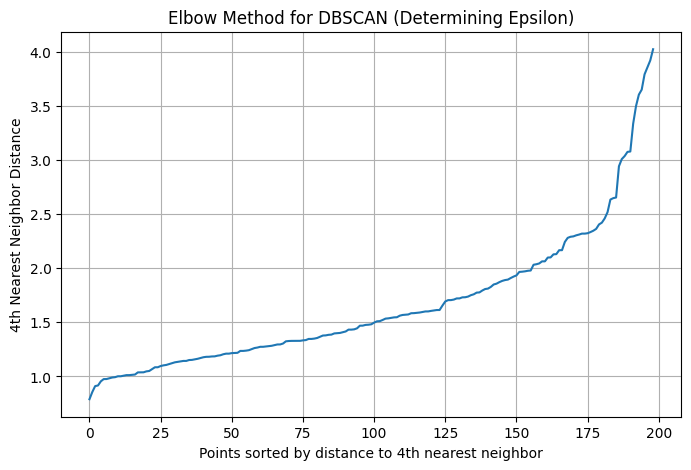

In [ ]:


distances = np.sort(distances[:, 4])  # 4th nearest neighbor distances
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("Elbow Method for DBSCAN (Determining Epsilon)")
plt.xlabel("Points sorted by distance to 4th nearest neighbor")
plt.ylabel("4th Nearest Neighbor Distance")
plt.grid()
plt.show()


In [ ]:
eps_value = 3.0

dbscan = DBSCAN(eps=eps_value, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)

customer_data['Cluster'] = dbscan_labels


unique_clusters = [label for label in np.unique(dbscan_labels) if label != -1]

In [ ]:
print(f"Number of noise points: {(dbscan_labels == -1).sum()}")

Number of noise points: 5


Handling noise points
DBScan will not consider a noise/outlier point in any cluster. They are assigned a label of -1. For such points, we will assign the nearest cluster as its cluster

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min


if -1 in dbscan_labels:
    centroids = np.array([
        scaled_data[dbscan_labels == cluster].mean(axis=0)
        for cluster in unique_clusters
    ])

    noise_indices = np.where(dbscan_labels == -1)[0]

    nearest_clusters, _ = pairwise_distances_argmin_min(
        scaled_data[noise_indices], centroids
    )

    for idx, cluster_id in zip(noise_indices, nearest_clusters):
        customer_data.at[idx, 'Cluster'] = unique_clusters[cluster_id]


customer_data['Cluster'] = customer_data['Cluster'].astype(int)



Visualization of Clusters using t-SNE

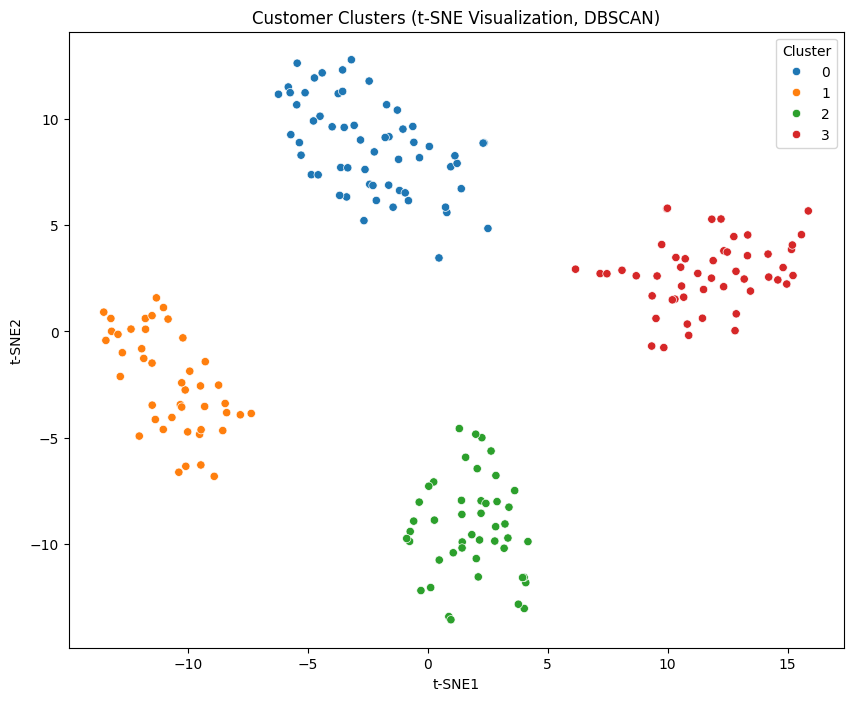

In [ ]:



tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)

customer_data['t-SNE1'] = tsne_results[:, 0]
customer_data['t-SNE2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2', hue='Cluster', data=customer_data,
    palette='tab10', legend='full'
)
plt.title("Customer Clusters (t-SNE Visualization, DBSCAN)")
plt.show()




Printing DB Index for DBSCAN

In [ ]:
final_db_index = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f"Davies-Bouldin Index (DBSCAN): {final_db_index}")



Davies-Bouldin Index (DBSCAN): 1.1474339017394706


Printing cluster information

In [ ]:
cluster_groups = customer_data.groupby('Cluster')['CustomerID'].apply(list)
for cluster_id, customers in cluster_groups.items():
    print(f"Cluster {cluster_id}: {len(customers)} customers")

Cluster 0: 59 customers
Cluster 1: 44 customers
Cluster 2: 46 customers
Cluster 3: 50 customers


In [ ]:
for cluster_id, customers in cluster_groups.items():
    print(f"Cluster {cluster_id}:")
    print(customers)
    print("-" * 50)

Cluster 0:
['C0001', 'C0003', 'C0004', 'C0006', 'C0011', 'C0012', 'C0013', 'C0025', 'C0031', 'C0032', 'C0039', 'C0048', 'C0052', 'C0071', 'C0076', 'C0077', 'C0082', 'C0083', 'C0085', 'C0087', 'C0091', 'C0095', 'C0096', 'C0099', 'C0102', 'C0104', 'C0107', 'C0108', 'C0112', 'C0113', 'C0118', 'C0120', 'C0126', 'C0129', 'C0130', 'C0133', 'C0137', 'C0147', 'C0148', 'C0150', 'C0151', 'C0152', 'C0153', 'C0155', 'C0158', 'C0163', 'C0165', 'C0168', 'C0169', 'C0171', 'C0174', 'C0181', 'C0184', 'C0187', 'C0188', 'C0190', 'C0191', 'C0192', 'C0195']
--------------------------------------------------
Cluster 1:
['C0002', 'C0005', 'C0007', 'C0021', 'C0022', 'C0027', 'C0028', 'C0040', 'C0043', 'C0045', 'C0054', 'C0056', 'C0078', 'C0080', 'C0084', 'C0088', 'C0090', 'C0092', 'C0093', 'C0097', 'C0101', 'C0106', 'C0110', 'C0115', 'C0123', 'C0128', 'C0134', 'C0136', 'C0138', 'C0140', 'C0142', 'C0143', 'C0145', 'C0146', 'C0159', 'C0161', 'C0162', 'C0173', 'C0175', 'C0177', 'C0178', 'C0186', 'C0193', 'C0200'